Author: <font color="blue">Josep Monclús Carrasco</font>

E-mail: <font color="blue">josep.monclus01@estudiant.upf.edu</font>

Date: <font color="blue">7/11/2021</font>

# 0.1. Load the input files

In [1]:
# Leave this code as-is

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from math import*
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Leave this code as-is
#i change the path to /data/file
FILENAME_RATINGS = "data/ratings.dat"
FILENAME_USERS = "data/users.dat"
FILENAME_MOVIES = "data/movies.dat"

In [3]:
# Leave this code as-is

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep='::', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

users = pd.read_csv(FILENAME_USERS, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
_ = users.set_index('user_id')

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
_ = movies.set_index('movie_id')

# 0.2. Merge the data into a single dataframe

In [4]:
ratings_r = pd.merge(ratings_raw,users,on="user_id")
ratings = pd.merge(ratings_r,movies,on="movie_id")
ratings.head(5)

,user_id,movie_id,rating,timestamp,gender,age,occupation,zipcode,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [5]:
import re
def find_movies(tit,movies):
    inds = []
    for i,mov in enumerate(movies.title):
        if re.search(tit,mov):
            inds.append(i)
    movs = movies.iloc[inds]
    return movs
find_movies("Godfather", movies)

,movie_id,title,genres
847,858,"Godfather, The (1972)",Action|Crime|Drama
1203,1221,"Godfather: Part II, The (1974)",Action|Crime|Drama
1954,2023,"Godfather: Part III, The (1990)",Action|Crime|Drama


# 1. Exploratory Data Analysis

## 1.1. Unique registers

In [6]:
from collections import Counter
print("Number of users :",len(ratings["user_id"].unique()))
print("Number of movies :",len(ratings["movie_id"].unique()))

Number of users : 6040
Number of movies : 3706


## 1.2. Age differences in ratings

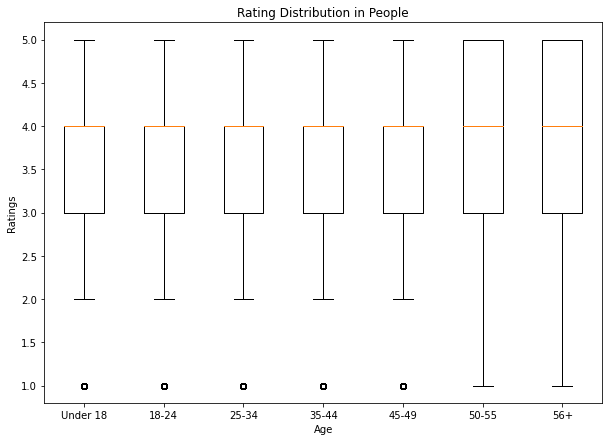

In [7]:
data = [ratings.rating[ratings["age"]==1],ratings.rating[ratings["age"]==18],
       ratings.rating[ratings["age"]==25],ratings.rating[ratings["age"]==35],
       ratings.rating[ratings["age"]==45],ratings.rating[ratings["age"]==50],
       ratings.rating[ratings["age"]==56]]
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_subplot(111) 
box = plt.boxplot(data)
ax.set_ylabel("Ratings")
ax.set_xlabel("Age")
ax.set_title("Rating Distribution in People")
# x-axis labels 
ax.set_xticklabels(["Under 18", "18-24",  
                    "25-34", "35-44",
                   "45-49","50-55","56+"]) 

plt.show()

As we can see there is no a lot of difference in the ratings of people with ages between 1 and 49 and there are similar the ratings of the people of 50 and more years. The first strata comented vote commonly medium high ratings like 3,4 and the second strata vote higger but it votes low too.

Counter({25: 395556, 35: 199003, 18: 183536, 45: 83633, 50: 72490, 56: 38780, 1: 27211})


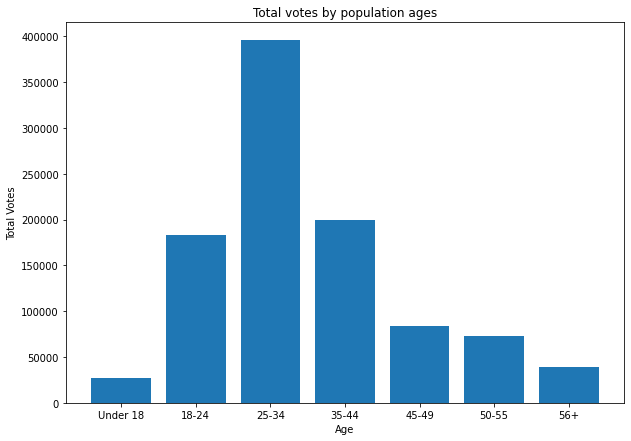

In [8]:
from collections import Counter
count = Counter(ratings.age)
print(count)
#hist = np.histogram(ratings.age,bins=7)
ages = ["Under 18", "18-24",  
                    "25-34", "35-44",
                   "45-49","50-55","56+"]
values = [count[1],count[18],count[25],count[35],count[45],count[50],count[56]]
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_subplot(111) 
plt.bar(ages,values)
ax.set_ylabel("Total Votes")
ax.set_xlabel("Age")
ax.set_title("Total votes by population ages")
plt.show()

The people who more vote are the population between 25 and 34 years

# 2. Item-based Collaborative Filtering

## 2.1. Data pre-processing

In [9]:
rated_movies = pd.merge(ratings_r,movies,on="movie_id")
rated_movies = rated_movies.drop(columns = ["timestamp","gender","age","occupation","zipcode","genres"],axis = 1) 
rated_movies.head(5)

,user_id,movie_id,rating,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975)


In [10]:
ratings_summary = rated_movies
summ = ratings_summary.groupby('movie_id').rating.agg(["count","mean"])
summ = summ.rename(columns={'count': 'ratings_count', 'mean': 'ratings_mean'})
ratings_summary = pd.merge(summ,rated_movies,on="movie_id")
ratings_summary = ratings_summary.drop(columns = ["user_id","rating"],axis = 1)
ratings_summary = ratings_summary.drop_duplicates()
ratings_summary.head(5)

,movie_id,ratings_count,ratings_mean,title
0,1,2077,4.146846,Toy Story (1995)
2077,2,701,3.201141,Jumanji (1995)
2778,3,478,3.016736,Grumpier Old Men (1995)
3256,4,170,2.729412,Waiting to Exhale (1995)
3426,5,296,3.006757,Father of the Bride Part II (1995)


In [11]:
more_than_1000 = ratings_summary[ratings_summary.ratings_count >= 1000]
more_than_1000 = more_than_1000.sort_values(by='ratings_mean', ascending=False)
more_than_1000.head(10)

,movie_id,ratings_count,ratings_mean,title
84501,318,2227,4.554558,"Shawshank Redemption, The (1994)"
206777,858,2223,4.524966,"Godfather, The (1972)"
23302,50,1783,4.517106,"Usual Suspects, The (1995)"
141660,527,2304,4.510417,Schindler's List (1993)
301528,1198,2514,4.477725,Raiders of the Lost Ark (1981)
215009,904,1050,4.476190,Rear Window (1954)
67447,260,2991,4.453694,Star Wars: Episode IV - A New Hope (1977)
191596,750,1367,4.449890,Dr. Strangelove or: How I Learned to Stop Worr...
219595,912,1669,4.412822,Casablanca (1942)
745569,2762,2459,4.406263,"Sixth Sense, The (1999)"


In [12]:
more_than_3 = ratings_summary[ratings_summary.ratings_count >= 3]
more_than_3 = more_than_3.sort_values(by='ratings_mean', ascending=False)
more_than_3.head(10)

,movie_id,ratings_count,ratings_mean,title
198749,787,3,5.000000,"Gate of Heavenly Peace, The (1995)"
861004,3245,5,4.800000,I Am Cuba (Soy Cuba/Ya Kuba) (1964)
25516,53,8,4.750000,Lamerica (1994)
680081,2503,9,4.666667,"Apple, The (Sib) (1998)"
778586,2905,69,4.608696,Sanjuro (1962)
551052,2019,628,4.560510,Seven Samurai (The Magnificent Seven) (Shichin...
84501,318,2227,4.554558,"Shawshank Redemption, The (1994)"
206777,858,2223,4.524966,"Godfather, The (1972)"
190432,745,657,4.520548,"Close Shave, A (1995)"
23302,50,1783,4.517106,"Usual Suspects, The (1995)"


As we can see there are better ratings like the first one that have perfect score, but the reason is because only 3 people rated this film, and this is not enought to take conclusions because maybe this 3 people love the film but the average people don't like it, and sometimes we only vote our favorite films and not the rest. So it is important the quantitie of people that vote one film.

## 2.2. Compute the user-movie matrix

In [13]:
user_movie = rated_movies.pivot_table(index="user_id",columns="movie_id",values="rating")
user_movie.head(10)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN


The problem with this matrix is that is extremly sparse and large, because not all the users rate all the films and not all the films are rated by all the users, so that is why we have that amount of NaNs values. We need missing value estimation.

# 2.3. Explore some correlations in the user-movie matrix

In [14]:
#We obtain the movie_id
Alien = find_movies("Alien",movies).movie_id.iloc[1]
Plante_Apes = find_movies("Planet of the Apes",movies).movie_id.iloc[0]
Home_alone = find_movies("Home Alone",movies).movie_id.iloc[0]
#We obtain the ratings
s1 = user_movie[Alien]
s2 = user_movie[Plante_Apes]
s3 = user_movie[Home_alone]
#We create ratings3
ratings3 = pd.concat([s1,s2,s3],axis = 1).dropna()
ratings3.head(10)

,1214,2529,586
user_id,,,
10,4.0,4.0,3.0
33,4.0,5.0,4.0
48,3.0,3.0,4.0
166,5.0,5.0,3.0
198,3.0,4.0,5.0
216,4.0,2.0,4.0
245,4.0,4.0,1.0
264,3.0,3.0,3.0
284,4.0,3.0,3.0


In [15]:
print("Similarity between 'Alien (1979)' and 'Planet of the Apes (1968)':",ratings3[1214].corr(ratings3[2529]))
print("Similarity between 'Alien (1979)' and 'Home Alone (1990)':",ratings3[1214].corr(ratings3[586]))
print("Similarity between 'Planet of the Apes (1968)' and 'Home Alone (1990)':",ratings3[2529].corr(ratings3[586]))


Similarity between 'Alien (1979)' and 'Planet of the Apes (1968)': 0.30991186468293813
Similarity between 'Alien (1979)' and 'Home Alone (1990)': 0.0634692929568645
Similarity between 'Planet of the Apes (1968)' and 'Home Alone (1990)': 0.23538358910765272


As we can see the correlations are not too big and all are positive. The bigger relation is between Alien and Planet of the Apes with 0.29, but this is not a significative value of correlation so we can say that in principle that there is no relation in the ratings of the users between this two films. With Alien and Home Alone the value is even smaller this mean that there is no relation on the ratings, so if the user votes positive alien we cannot know if is going to votate positive or negative the film Home Alone.

In [16]:
similar_to_alien = user_movie.corrwith(ratings3[1214]).dropna()
similar_to_alien

/Users/josepmoncluscarrasco/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/josepmoncluscarrasco/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


movie_id
1       0.151575
2       0.189121
3       0.047153
4       0.184880
5       0.330885
          ...   
3947    0.438529
3948    0.297213
3949    0.007681
3950    0.564288
3952    0.131716
Length: 3081, dtype: float64

In [17]:
corr_with_alien = pd.DataFrame(similar_to_alien)
corr_with_alien = corr_with_alien.rename(columns = {0: "corr"})
corr_with_alien = pd.merge(corr_with_alien,ratings_summary, on = "movie_id")
corr_with_alien_500 = corr_with_alien[corr_with_alien.ratings_count >= 500]
corr_with_alien_500.sort_values("corr",ascending=False).head(10)

,movie_id,corr,ratings_count,ratings_mean,title
924,1214,1.000000,2024,4.159585,Alien (1979)
910,1200,0.676805,1820,4.125824,Aliens (1986)
1502,1994,0.500405,795,3.684277,Poltergeist (1982)
1075,1387,0.498777,1697,4.089570,Jaws (1975)
1019,1320,0.491518,925,3.037838,Alien³ (1992)
1505,1997,0.475710,885,3.955932,"Exorcist, The (1973)"
42,45,0.470623,544,3.424632,To Die For (1995)
966,1258,0.446862,1087,4.104876,"Shining, The (1980)"
47,50,0.421131,1783,4.517106,"Usual Suspects, The (1995)"
746,968,0.419389,715,3.671329,Night of the Living Dead (1968)


As we can see obviusly the bigger correlation is with itself, and interesting the second bigger value is with Aliens, so this mean that the people who rate good Aliens, rate good Aliens and the same with bad rates, this could be because they have similar themes. Now we are going to try without limitating the rating_count.

In [18]:
corr_with_alien.sort_values("corr",ascending=False).head(10)

,movie_id,corr,ratings_count,ratings_mean,title
1860,2200,1.0,8,2.500000,Under Capricorn (1949)
3248,3772,1.0,3,1.666667,Hatchet For the Honeymoon (Rosso Segno Della F...
3342,3875,1.0,5,2.800000,"Devil Rides Out, The (1968)"
826,981,1.0,4,2.750000,Dangerous Ground (1997)
2544,2960,1.0,4,2.750000,Beefcake (1999)
1013,1214,1.0,2024,4.159585,Alien (1979)
1555,1886,1.0,4,2.750000,I Got the Hook Up (1998)
1476,1773,1.0,2,2.500000,Tokyo Fist (1995)
2281,2673,1.0,7,3.857143,Eternity and a Day (Mia eoniotita ke mia mera ...
3343,3876,1.0,4,2.000000,Jerry & Tom (1998)


As we can see, films with few ratings count apear but this not mean that there are similar, maybe the people who vote like the two films but the average people no, we are going to try other different limit count

In [19]:
corr_with_alien_100 = corr_with_alien[corr_with_alien.ratings_count >= 100]
corr_with_alien_100.sort_values("corr",ascending=False).head(10)

,movie_id,corr,ratings_count,ratings_mean,title
1013,1214,1.000000,2024,4.159585,Alien (1979)
999,1200,0.543713,1820,4.125824,Aliens (1986)
1518,1840,0.446851,160,3.381250,He Got Game (1998)
2918,3406,0.440847,105,3.752381,Captain Horatio Hornblower (1951)
1662,1997,0.429366,885,3.955932,"Exorcist, The (1973)"
1171,1387,0.411834,1697,4.089570,Jaws (1975)
1828,2166,0.405951,144,3.520833,Return to Paradise (1998)
1037,1240,0.398378,2098,4.152050,"Terminator, The (1984)"
1152,1366,0.398304,108,3.185185,"Crucible, The (1996)"
2206,2587,0.396278,102,2.960784,Life (1999)


In [20]:
corr_with_alien_200 = corr_with_alien[corr_with_alien.ratings_count >= 200]
corr_with_alien_200.sort_values("corr",ascending=False).head(10)

,movie_id,corr,ratings_count,ratings_mean,title
1013,1214,1.000000,2024,4.159585,Alien (1979)
999,1200,0.543713,1820,4.125824,Aliens (1986)
1662,1997,0.429366,885,3.955932,"Exorcist, The (1973)"
1171,1387,0.411834,1697,4.089570,Jaws (1975)
1037,1240,0.398378,2098,4.152050,"Terminator, The (1984)"
2596,3018,0.375170,248,3.475806,Re-Animator (1985)
2085,2454,0.374341,480,3.358333,"Fly, The (1958)"
2086,2455,0.372014,1071,3.440710,"Fly, The (1986)"
3183,3703,0.367116,1034,3.674081,Mad Max 2 (a.k.a. The Road Warrior) (1981)
44,45,0.366898,544,3.424632,To Die For (1995)


With more ratings_count we are going to have more acurracy because more people is voting

# 2.4. Implement the item-based recommendations

In [18]:
item_similarity = user_movie.corr()
item_similarity.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.187467,0.160649,0.348759,0.156957,0.051097,0.149536,0.151248,-0.039358,0.143598,...,-0.099845,0.174078,0.146344,0.135146,0.431743,0.139323,0.189518,0.146536,3.243253e-01,0.157996
2,0.187467,1.000000,0.149349,0.057874,0.384293,0.075067,0.251093,0.312949,0.407857,0.254558,...,0.009798,-1.000000,0.276240,0.133538,0.042524,0.216196,0.082241,-0.154672,-3.535534e-01,0.073111
3,0.160649,0.149349,1.000000,0.261800,0.399532,0.156934,0.220211,0.394405,0.151163,0.269250,...,-0.134059,0.239046,-0.361158,0.205521,-0.024042,0.314249,0.026743,0.445399,NaN,0.110024
4,0.348759,0.057874,0.261800,1.000000,0.401954,-0.012096,0.097271,0.074080,-0.681895,0.010868,...,0.589662,NaN,NaN,0.158114,-0.500000,0.209258,-0.434783,0.500000,1.922963e-16,0.154463
5,0.156957,0.384293,0.399532,0.401954,1.000000,0.075755,0.276160,0.589313,0.538139,0.241397,...,-0.533114,0.188982,NaN,0.522037,0.960769,0.416291,-0.133077,0.650000,NaN,-0.033736


In [19]:
item_similarity_min_ratings = user_movie.corr(min_periods=100)
item_similarity_min_ratings.head(5)

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
movie_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.187467,0.160649,0.348759,0.156957,0.051097,0.149536,NaN,NaN,0.143598,...,NaN,NaN,NaN,NaN,NaN,0.139323,0.189518,NaN,NaN,0.157996
2,0.187467,1.000000,0.149349,NaN,0.384293,0.075067,0.251093,NaN,NaN,0.254558,...,NaN,NaN,NaN,NaN,NaN,0.216196,NaN,NaN,NaN,NaN
3,0.160649,0.149349,1.000000,NaN,0.399532,0.156934,0.220211,NaN,NaN,0.269250,...,NaN,NaN,NaN,NaN,NaN,0.314249,NaN,NaN,NaN,NaN
4,0.348759,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.156957,0.384293,0.399532,NaN,1.000000,NaN,0.276160,NaN,NaN,0.241397,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#We take the rows that has ratign value gratter or equal to 4 on this films
user_id_rom = user_movie[(user_movie[587] >= 4) & (user_movie[1088] >= 4) & (user_movie[3257] >= 4)].iloc[0].name
print("User id who likes Romantic films",user_id_rom)

#We take the rows that has ratign value gratter or equal to 4 on this films
alien = user_movie[1214] >= 4
predator = user_movie[3527] >= 4
star_wars = user_movie[260] >= 4
user_id_sci = user_movie[(user_movie[1214] >= 4) & (user_movie[3527] >= 4) & (user_movie[260] >= 4)].iloc[0].name
print("User id who likes Science Fiction Films",user_id_sci)

User id who likes Romantic films 223
User id who likes Science Fiction Films 17


In [48]:
# Leave this code as-is

# Gets a list of watched movies for a user_id
def get_watched_movies(user_id, user_movie):
    return list(user_movie.loc[user_id].dropna().index)
    
# Gets the title of a movie by movie_id
def get_title(movie_id, movies):
    return movies[movies['movie_id'] == movie_id].title.iloc[0]

# Gets the rating a user_id has given to a movie_id
def get_rating(user_id, movie_id, user_movie):
    return user_movie[movie_id][user_id]

# Print watched movies
def print_watched_movies(user_id, user_movie, movies):
    for movie_id in get_watched_movies(user_id, user_movie):
        print("%d %.1f %s " %
          (movie_id, get_rating(user_id, movie_id, user_movie), get_title(movie_id, movies)))

# Test functions
print_watched_movies(user_id_rom, user_movie, movies)

1 5.0 Toy Story (1995) 
2 5.0 Jumanji (1995) 
3 4.0 Grumpier Old Men (1995) 
15 3.0 Cutthroat Island (1995) 
24 5.0 Powder (1995) 
31 3.0 Dangerous Minds (1995) 
34 4.0 Babe (1995) 
60 3.0 Indian in the Cupboard, The (1995) 
95 4.0 Broken Arrow (1996) 
104 3.0 Happy Gilmore (1996) 
110 3.0 Braveheart (1995) 
135 4.0 Down Periscope (1996) 
150 4.0 Apollo 13 (1995) 
151 1.0 Rob Roy (1995) 
153 3.0 Batman Forever (1995) 
158 3.0 Casper (1995) 
168 4.0 First Knight (1995) 
170 5.0 Hackers (1995) 
174 3.0 Jury Duty (1995) 
188 5.0 Prophecy, The (1995) 
193 3.0 Showgirls (1995) 
208 4.0 Waterworld (1995) 
231 5.0 Dumb & Dumber (1994) 
253 5.0 Interview with the Vampire (1994) 
266 1.0 Legends of the Fall (1994) 
288 1.0 Natural Born Killers (1994) 
292 5.0 Outbreak (1995) 
316 1.0 Stargate (1994) 
317 3.0 Santa Clause, The (1994) 
325 2.0 National Lampoon's Senior Trip (1995) 
329 3.0 Star Trek: Generations (1994) 
344 3.0 Ace Ventura: Pet Detective (1994) 
353 4.0 Crow, The (1994) 
356 5.0 

In [49]:
def get_movies_relevance(user_id, user_movie, item_similarity_matrix):

    # Create an empty series
    movies_relevance = pd.Series('object')
    # Iterate through the movies the user has watched
    for watched_movie in user_movie.iloc[user_id].dropna().index:

        # Obtain the rating given
        rating_given = user_movie[watched_movie].iloc[user_id]

        # Obtain the vector containing the similarities of watched_movie
        # with all other movies in item_similarity_matrix
        similarities = item_similarity_matrix[watched_movie]

        # Multiply this vector by the given rating
        weighted_similarities = similarities * rating_given

        # Append these terms to movies_relevance
        movies_relevance = movies_relevance.append(weighted_similarities)

    # Compute the sum for each movie
    movies_relevance = movies_relevance.groupby(movies_relevance.index).sum()

    # Convert to a dataframe
    movies_relevance_df = pd.DataFrame(movies_relevance, columns=['relevance'])
    movies_relevance_df['movie_id'] = movies_relevance_df.index

    return movies_relevance_df

In [50]:
relevant = get_movies_relevance(user_id_rom, user_movie, item_similarity_min_ratings)
#We merge with movies to have the movie atributes
rel = pd.merge(relevant,movies,on="movie_id").sort_values("relevance",ascending=False)
#We show the 10 more relevant
rel.head(10)

,relevance,movie_id,title,genres
2592,129.495766,2797,Big (1988),Comedy|Fantasy
1167,124.920145,1259,Stand by Me (1986),Adventure|Comedy|Drama
1207,123.618167,1299,"Killing Fields, The (1984)",Drama|War
3293,122.029381,3526,Parenthood (1989),Comedy|Drama
3216,121.492483,3448,"Good Morning, Vietnam (1987)",Comedy|Drama|War
957,121.341103,1022,Cinderella (1950),Animation|Children's|Musical
1964,120.859539,2145,Pretty in Pink (1986),Comedy|Drama|Romance
1781,120.434457,1961,Rain Man (1988),Drama
581,118.232942,595,Beauty and the Beast (1991),Animation|Children's|Musical
2214,117.140884,2407,Cocoon (1985),Comedy|Sci-Fi


In [51]:
relevant2 = get_movies_relevance(user_id_sci, user_movie, item_similarity_min_ratings)
#We merge with movies to have the movie atributes
rel2 = pd.merge(relevant2,movies,on="movie_id").sort_values("relevance",ascending=False)
#We show the 10 more relevant
rel2.head(10)

,relevance,movie_id,title,genres
957,239.847522,1022,Cinderella (1950),Animation|Children's|Musical
2592,233.615264,2797,Big (1988),Comedy|Fantasy
3351,228.17874,3591,Mr. Mom (1983),Comedy|Drama
1899,226.934526,2080,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
354,226.262059,364,"Lion King, The (1994)",Animation|Children's|Musical
1821,223.826358,2001,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama
1820,220.338305,2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama
2277,219.694658,2470,Crocodile Dundee (1986),Adventure|Comedy
2438,219.570915,2640,Superman (1978),Action|Adventure|Sci-Fi
1904,217.667918,2085,101 Dalmatians (1961),Animation|Children's


The relevant films for the Sci guy/girl are not perfect, we have 5/6 that i found relevant up to the 10 expected ones. On the other hand the relevants for Romantic guy/girl are sligthy better with 7/8 that i found relevants.

In [52]:
def get_recomender_movies(user_id, user_movie, item_similarity_matrix):
    """
    This function return movies ordered by relevance for one user
    """
    #Obtain the dataframe of relevant movies
    movies_relevance_df = get_movies_relevance(user_id, user_movie, item_similarity_matrix)
    #Set this dataframe index to 'movie_id'
    relevants = movies_relevance_df.set_index('movie_id')
    #Obtain the list of movie_ids of watched movies
    movies_watched = get_watched_movies(user_id, user_movie)
    #Drop from the relevant movies dataframe the watched movies
    recomended_movies = relevants.drop(movies_watched)
    return recomended_movies

In [53]:
recomended = get_recomender_movies(user_id_rom, user_movie, item_similarity_min_ratings)
#We merge with movies to have the movie atributes
rec = pd.merge(recomended,movies,on="movie_id").sort_values("relevance",ascending=False)
#We show the 10 more relevant
rec.head(10)

,movie_id,relevance,title,genres
1110,1299,123.618167,"Killing Fields, The (1984)",Drama|War
3052,3526,122.029381,Parenthood (1989),Comedy|Drama
880,1022,121.341103,Cinderella (1950),Animation|Children's|Musical
1802,2145,120.859539,Pretty in Pink (1986),Comedy|Drama|Romance
520,595,118.232942,Beauty and the Beast (1991),Animation|Children's|Musical
2033,2407,117.140884,Cocoon (1985),Comedy|Sci-Fi
2235,2640,116.894439,Superman (1978),Action|Adventure|Sci-Fi
3197,3685,116.645234,Prizzi's Honor (1985),Comedy|Drama|Romance
3108,3591,115.477614,Mr. Mom (1983),Comedy|Drama
1049,1231,114.467742,"Right Stuff, The (1983)",Drama


In [54]:
recomended2 = get_recomender_movies(user_id_sci, user_movie, item_similarity_min_ratings)
#We merge with movies to have the movie atributes
rec2 = pd.merge(recomended2,movies,on="movie_id").sort_values("relevance",ascending=False)
#We show the 10 more relevant
rec2.head(10)

,movie_id,relevance,title,genres
906,1022,239.847522,Cinderella (1950),Animation|Children's|Musical
2438,2797,233.615264,Big (1988),Comedy|Fantasy
3164,3591,228.17874,Mr. Mom (1983),Comedy|Drama
1790,2080,226.934526,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance
330,364,226.262059,"Lion King, The (1994)",Animation|Children's|Musical
1719,2001,223.826358,Lethal Weapon 2 (1989),Action|Comedy|Crime|Drama
1718,2000,220.338305,Lethal Weapon (1987),Action|Comedy|Crime|Drama
2148,2470,219.694658,Crocodile Dundee (1986),Adventure|Comedy
1795,2085,217.667918,101 Dalmatians (1961),Animation|Children's
1733,2018,217.321166,Bambi (1942),Animation|Children's


Looking to the films that the sistem recomends and the different genres, the sistem suggest a different variety of films from different genres based on the other films that he rated, this is more acurate that the past practise aproach where we only base our model on the genre of the film, so this give us better results, otherwise the recomendations fro a Romantic guy/girl are not perfect because maybe is not looking to see Cocoon (1985) for example. The relevance scores are quite similar than in the previous containing all relevant movies.

<font size="+2" color="blue">Additional results: surprise library</font>

In [38]:
#!pip install scikit-surprise

In [55]:
#We convert the file to the expected format of the model
f = open("data/ratings.dat","r")
lines = f.readlines()
w = open("data/ratings2.dat","w")
for line in lines:
    #The expected format is having the atributes splited by \t (tabulator)
    l = line.replace("::","\t")
    w.write(l)
f.close()
w.close()

In [56]:
#We import the need it modules
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

#We define the Reader format to load the data
reader = Reader(line_format='user item rating timestamp', sep='\t')
# Load the movies
data = Dataset.load_from_file("data/ratings2.dat", reader=reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8771


0.8771106640820825

Using the predictor to the user 223 with the film Dirty Dancing we expect a good vote because is a Romantic film and the user 223 likes Romantic films

In [57]:
uid = str(26)  # raw user id (as in the ratings file). They are **strings**!
iid = str(1088)  # raw item id (as in the ratings file). They are **strings**!

#movie_id Dirty Dancing (1987) which is a Romantic Film
#User id who likes Romantic films 26

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)[3]
print(pred)

user: 26         item: 1088       r_ui = 4.00   est = 3.48   {'was_impossible': False}
3.478977456671436


### Giving Recomendations based on the expected rating

In [58]:
def get_recomentations(user_id,movies,model,user_movie):
    #We create two empty list to save the predicted ratings to the title movies
    predicted_ratings = []
    title_movie = []
    #We loop though the movies id
    for i,movie_id in enumerate(movies["movie_id"]):
        #We predict the rating and append it
        predicted_ratings.append(model.predict(str(user_id),str(movie_id),r_ui=4)[3])
        title_movie.append(movies.title[i])
    #We transform the lists into a Series
    a = pd.Series(predicted_ratings)
    b = pd.Series(title_movie)
    s = pd.concat([a,b,movies["movie_id"]],axis=1)
    #We transform the concated Series into a dataframe
    df = pd.DataFrame(s)
    df = df.rename(columns={0: 'predicted_ratings', 1: 'title_movie'})
    relevants = df.set_index('movie_id')
    #We drop from the recomendation the watched movies
    movies_watched = get_watched_movies(user_id, user_movie)
    recomended_movies = relevants.drop(movies_watched)
    return recomended_movies

In [59]:
df = get_recomentations(26,movies,algo,user_movie)
df.sort_values("predicted_ratings",ascending=False).head(10)

,predicted_ratings,title_movie
movie_id,,
2935,4.461504,"Lady Eve, The (1941)"
3578,4.440274,Gladiator (2000)
2396,4.377420,Shakespeare in Love (1998)
2762,4.342657,"Sixth Sense, The (1999)"
1260,4.319969,M (1931)
1408,4.219193,"Last of the Mohicans, The (1992)"
326,4.213949,To Live (Huozhe) (1994)
3949,4.210504,Requiem for a Dream (2000)
1233,4.191282,"Boat, The (Das Boot) (1981)"


In [60]:
df2 = get_recomentations(1,movies,algo,user_movie)
df2.sort_values("predicted_ratings",ascending=False).head(10)

,predicted_ratings,title_movie
movie_id,,
2905,4.822105,Sanjuro (1962)
668,4.802314,Pather Panchali (1955)
913,4.795972,"Maltese Falcon, The (1941)"
1172,4.794124,Cinema Paradiso (1988)
1148,4.790050,"Wrong Trousers, The (1993)"
318,4.785809,"Shawshank Redemption, The (1994)"
2019,4.779101,Seven Samurai (The Magnificent Seven) (Shichin...
1278,4.777111,Young Frankenstein (1974)
2208,4.758263,"Lady Vanishes, The (1938)"


<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>